## Classification on Tabular Data
***
* Dataset: https://www.kaggle.com/c/cat-in-the-dat-ii
* We will learn how to use CrossValidation with torchflare.

In [1]:
import numpy as np  
import pandas as pd  
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os
import copy
import traceback
import datetime
import random

from torchflare.experiments import Experiment
import torchflare.metrics as metrics
import torchflare.callbacks as cbs
import torchflare.criterion as crit
from torchflare.datasets import TabularDataset , CVSplit

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
def reduce_mem_usage(df, verbose=True):
    '''
    Reduce file memory usage
    Source: https://www.kaggle.com/artgor
    
    Parameters:
    -----------
    df: DataFrame
        Dataset on which to perform transformation
    verbose: bool
        Print additional information
    Returns:
    --------
    DataFrame
        Dataset as pandas DataFrame
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16)\
                                               .max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32)\
                                                .max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
                                               .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return (df)


<IPython.core.display.Javascript object>

In [4]:
train_df = pd.read_csv("train.csv")
features = train_df.columns.difference(["id", "target"]).tolist()
target = "target"

<IPython.core.display.Javascript object>

In [5]:
label_encoders = {}
for cat_col in features:
    label_encoders[cat_col] = LabelEncoder()
    train_df[cat_col] = label_encoders[cat_col].fit_transform(
        train_df[cat_col].astype("category").cat.codes.fillna(-1).values
    )

train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 19.46 Mb (83.0% reduction)


<IPython.core.display.Javascript object>

In [6]:
cat_dims = [int(train_df[col].nunique()) for col in features]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

<IPython.core.display.Javascript object>

In [7]:
class Model(nn.Module):
    def __init__(
        self, emb_dims, lin_layer_sizes, output_size, emb_dropout, lin_layer_dropouts
    ):
        """
        emb_dims: List of two element tuples
        For each categorical feature the first element of a tuple will
        denote the number of unique values of the categorical
        feature. The second element will denote the embedding
        dimension to be used for that feature.
        """

        super(Model, self).__init__()

        # Embedding layers
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        self.no_of_embs = sum([y for x, y in emb_dims])

        # Linear Layers
        first_lin_layer = nn.Linear(
            in_features=self.no_of_embs, out_features=lin_layer_sizes[0]
        )

        self.lin_layers = nn.ModuleList(
            [first_lin_layer]
            + [
                nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
                for i in range(len(lin_layer_sizes) - 1)
            ]
        )

        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_embs)
        self.bn_layers = nn.ModuleList(
            [nn.BatchNorm1d(size) for size in lin_layer_sizes]
        )

        # Dropout Layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.droput_layers = nn.ModuleList(
            [nn.Dropout(size) for size in lin_layer_dropouts]
        )

    def forward(self, cat_data):

        if self.no_of_embs != 0:
            x = [
                emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)
            ]
            x = torch.cat(x, 1)
            x = self.first_bn_layer(x)
            x = self.emb_dropout_layer(x)

        for lin_layer, dropout_layer, bn_layer in zip(
            self.lin_layers, self.droput_layers, self.bn_layers
        ):

            x = F.relu(lin_layer(x))
            x = dropout_layer(x)
            x = bn_layer(x)

        x = self.output_layer(x)
        return x

<IPython.core.display.Javascript object>

In [8]:
n_splits = 3

<IPython.core.display.Javascript object>

In [9]:
ds = TabularDataset.from_df(df=train_df, feature_cols=features, label_cols=target)


cv = CVSplit(
    dataset=ds, cv="StratifiedKFold", n_splits=n_splits, shuffle=True, random_state=42
)
train_dl_params = {"batch_size": 32, "shuffle": True, "num_workers": 0}
valid_dl_params = {"batch_size": 32, "shuffle": True, "num_workers": 0}

<IPython.core.display.Javascript object>

Fold:0

Epoch: 1/3
Train: 12500/12500 [=========================]- 99s 8ms/step - train_loss: 0.4703 - train_accuracy: 0.8084
Valid: 6250/6250 [=========================]- 12s 2ms/step - val_loss: 0.4226 - val_accuracy: 0.8099

Epoch: 2/3
Train: 12500/12500 [=========================]- 94s 8ms/step - train_loss: 0.4306 - train_accuracy: 0.8116
Valid: 6250/6250 [=========================]- 13s 2ms/step - val_loss: 0.4112 - val_accuracy: 0.8119

Epoch: 3/3
Train: 12500/12500 [=========================]- 101s 8ms/step - train_loss: 0.4221 - train_accuracy: 0.8126
Valid: 6250/6250 [=========================]- 14s 2ms/step - val_loss: 0.4056 - val_accuracy: 0.8131


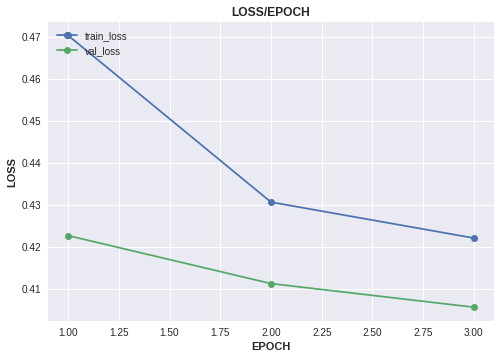

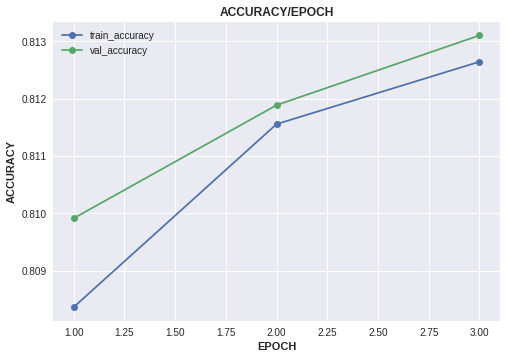

Fold:1

Epoch: 1/3
Train: 12500/12500 [=========================]- 104s 8ms/step - train_loss: 0.4710 - train_accuracy: 0.8088
Valid: 6250/6250 [=========================]- 14s 2ms/step - val_loss: 0.4230 - val_accuracy: 0.8102

Epoch: 2/3
Train: 12500/12500 [=========================]- 106s 8ms/step - train_loss: 0.4307 - train_accuracy: 0.8117
Valid: 6250/6250 [=========================]- 15s 2ms/step - val_loss: 0.4098 - val_accuracy: 0.8124

Epoch: 3/3
Train: 12500/12500 [=========================]- 108s 9ms/step - train_loss: 0.4220 - train_accuracy: 0.8130
Valid: 6250/6250 [=========================]- 15s 2ms/step - val_loss: 0.4064 - val_accuracy: 0.8133


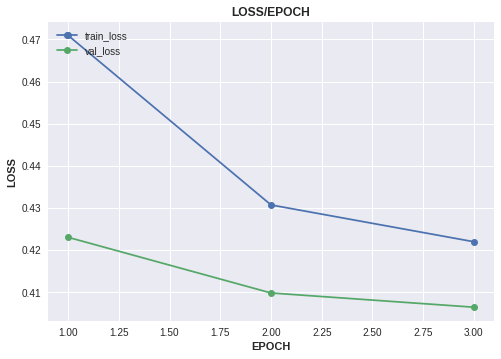

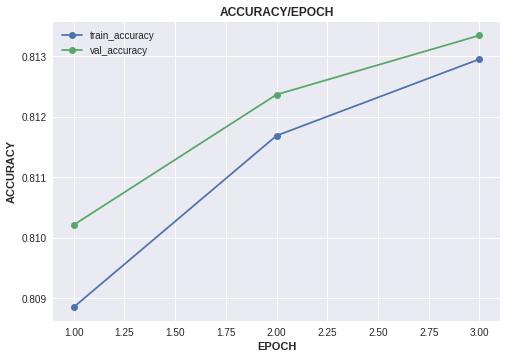

Fold:2

Epoch: 1/3
Train: 12500/12500 [=========================]- 109s 9ms/step - train_loss: 0.4702 - train_accuracy: 0.8088
Valid: 6250/6250 [=========================]- 15s 2ms/step - val_loss: 0.4225 - val_accuracy: 0.8103

Epoch: 2/3
Train: 12500/12500 [=========================]- 110s 9ms/step - train_loss: 0.4301 - train_accuracy: 0.8118
Valid: 6250/6250 [=========================]- 15s 2ms/step - val_loss: 0.4111 - val_accuracy: 0.8121

Epoch: 3/3
Train: 12500/12500 [=========================]- 110s 9ms/step - train_loss: 0.4215 - train_accuracy: 0.8128
Valid: 6250/6250 [=========================]- 15s 2ms/step - val_loss: 0.4074 - val_accuracy: 0.8131


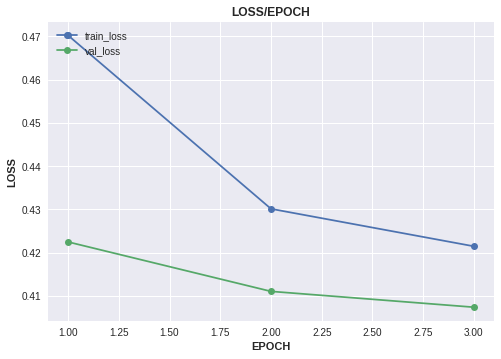

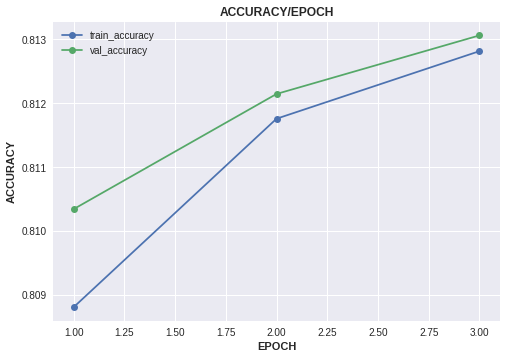

<IPython.core.display.Javascript object>

In [12]:
for fold in range(n_splits):

    print(f"Fold:{fold}")

    train_dl, valid_dl = cv.get_loaders(
        fold=fold, train_params=train_dl_params, val_params=valid_dl_params
    )

    metric_list = [metrics.Accuracy(num_classes=2, multilabel=False, threshold=0.6)]

    callbacks = [
        cbs.EarlyStopping(monitor="accuracy", patience=3, mode="max"),
        cbs.ModelCheckpoint(monitor="accuracy", mode="max"),
        cbs.ReduceLROnPlateau(mode="max", patience=2),
    ]

    model = Model(
        emb_dims,
        lin_layer_sizes=[200, 200],
        output_size=1,
        emb_dropout=0.3,
        lin_layer_dropouts=[0.3, 0.3],
    )

    exp = Experiment(
        num_epochs=3,
        fp16=False,
        device="cuda",
        seed=42,
    )

    exp.compile_experiment(
        model=model,
        optimizer="Adam",
        optimizer_params=dict(lr=3e-4),
        callbacks=callbacks,
        criterion=crit.BCEWithLogitsFlat,
        metrics=metric_list,
        main_metric="accuracy",
    )
    exp.fit_loader(train_dl, valid_dl)
    keys = ["loss", "accuracy"]
    exp.plot_history(keys=keys, save_fig=False, plot_fig=True)